In [1]:
%matplotlib notebook
from ipywidgets import *

import rospy
import rospkg
import os.path

from mag_manip.mag_manip import *
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.transforms as mtransforms
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from matplotlib import cm
import matplotlib as mpl
import numpy as np
import math
import yaml
from scipy.linalg import null_space

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from itertools import combinations
from scipy.spatial import ConvexHull

In [2]:
#Create customized color bar

N = 256
vals = np.ones((N, 4))
vals_seg1 = np.ones((N, 4))
vals_seg2 = np.ones((N, 4))

col1 = [70, 130, 180]
col2 = [214, 244, 255]
col3 = [227, 158, 33]
 

vals_seg1[:, 0] = np.linspace(col1[0]/256, col2[0]/256, N)
vals_seg1[:, 1] = np.linspace(col1[1]/256, col2[1]/256, N)
vals_seg1[:, 2] = np.linspace(col1[2]/256, col2[2]/256, N)

vals_seg2[:, 0] = np.linspace(col2[0]/256, col3[0]/256, N)
vals_seg2[:, 1] = np.linspace(col2[1]/256, col3[1]/256, N)
vals_seg2[:, 2] = np.linspace(col2[2]/256, col3[2]/256, N)

vals = np.concatenate((vals_seg1,vals_seg2))

cmp_blue_3col = ListedColormap(vals)

# Workspace and analysis of 2d electromagnetic navigation systems

## Functions for feasibility test with zonotopes

Approach proposed in [Bouchard 2008](https://asmedigitalcollection.asme.org/mechanismsrobotics/article/2/1/011010/475593/On-the-Ability-of-a-Cable-Driven-Robot-to-Generate) to check if required field can be generated in one position. 

In [3]:
#Compute the vertices of the convex hull defining the zonotope
def ComputeZonotopeVertices(Imin,Imax,J):

    N = np.shape(J)[1]
    pts = np.stack(([0,1],)*N,0)
    A_alpha = np.transpose((np.array(np.meshgrid(*pts)).T).reshape(2**N,N)) #compute permutation matrix
    
    M = np.matmul(J,(Imax - Imin)*np.eye(N))
    C = np.matmul(M,A_alpha)
    
    hull = ConvexHull(np.transpose(C))
    hull_idx = hull.vertices
    C_hull = C[:,hull_idx]
    
    vert = np.transpose(C_hull + np.matmul(J,Imin*np.ones((N,1))))
    
    return vert

#Create permutation matrix for the selection of unitary actuation fields
def CreatePermuationMatrix(A):
    
    d = np.shape(A)[0] #dimension of output space (if field, this is 3)
    n = np.shape(A)[1] #number of coils
    
    comb = combinations(np.arange(n), d-1) 

    M = np.asarray(list(comb))  
    
    return M

#Create combination matrix to test combination of field
def CreateFieldCombinationMatrix(n):

    nums = np.arange(2**n)
    M = ((nums.reshape(-1,1) & (2**np.arange(n))) != 0).astype(int)
    
    return M

#Compute the hyperplane representation of the zonotope
def HyperPlaneShiftingMethod(A,Imin,Imax):
    
    dI = Imax - Imin
    M = CreatePermuationMatrix(A)
    nb_comb = np.shape(M)[0] #number of combination
    
    d = np.shape(A)[0] #dimension of output space (if field, this is 3)
    n_coils = np.shape(A)[1] #number of coils
    
    #Initialize matrix and vector for hyperplane representation
    N = np.zeros((2*nb_comb,d))
    d_vec = np.zeros((2*nb_comb,1))
    
    bmin = np.matmul(A,Imin*np.ones((n_coils,1)))
    
    #Iterate on the combination of unitary fields
    for i in range(nb_comb):
        
            
        # Step 1: define initial hyperplane
        
        #Define the set of vectors to be orthogonal with
        W = A[:,M[i,:]]
        
        #Get the orthogonal vector using the nullspace of W^T
        Wns = null_space(np.transpose(W))
        v = Wns[:,0]

        # Step 2: shift intial hyperplane
        temp = v / np.linalg.norm(v)
        n = temp.reshape((-1,1))
        
        # Step 3: build projections   
        lj_arr = np.zeros((n_coils-(d-1),1))
        k = 0
        h = 0. 
        for j in range(n_coils):
            if not(j in M[i,:]):
                lj = np.dot(np.transpose(A[:,j]),n)
                lj_arr[k,0] = lj
                k += 1

        C = CreateFieldCombinationMatrix(n_coils-(d-1))
        
        h = np.matmul(C,dI*lj_arr)
        
        hp = np.max(h)
        hm = np.min(h)
        
        #Step 4: compute hyperplane support
        pp = hp*n + bmin
        pm = hm*n + bmin
        
        
        # Step 5: build hyperplane representation
        N[i,:] = n.T
        N[i+nb_comb,:] = -n.T
        d_vec[i,:] = np.dot(n.T,pp)
        d_vec[i+nb_comb,:] = np.dot(-n.T,pm)
            
        
    return N, d_vec

#Check if a given task field set of the form of a convex polytope complies with the available field zonotope
#d, N is the hyperplane representation of the zonotope
#V contain the vertices of the polytope of the task field
def VerifyFeasabilityPolytope(d,N,V):
    
    D = np.repeat(d,np.shape(V)[1],axis=1)
    M = np.matmul(N,V) <= D
    isFeasible = np.all(M)
    
    return M, isFeasible

#Check if a given task field of the form of a point complies with the available field zonotope
#d, N is the hyperplane representation of the zonotope
#b contain the desired task field
def VerifyFeasabilityPoint(d,N,b):

    M = np.matmul(N,b) <= d
    isFeasible = np.all(M)
    
    return M, isFeasible

#Check if a given task field of the form of an ellipsoid complies with the available field zonotope
#d, N is the hyperplane representation of the zonotope
#a contain the half axes of the task field expressed as an ellipsoid
def VerifyFeasabilityEllipsoid(d,N,a):

    #Assume feasibility a priori
    isFeasible = True

    for i in range(N.shape[0]):
        
        n = np.transpose(N[i,:])
        kinv = 0
        
        for j in range(N.shape[1]):
            kinv = kinv + (a[j]*n[j])**2
            
        k = 1 / math.sqrt(kinv)
        
        e_p = np.matmul(np.diag(a**2)*k, n)
        e_m = np.matmul(-np.diag(a**2)*k, n)
        
        #Test feasibility in the directions of the ellipsoid normals colinear to the hyperplanes of the available set
        M, isFeasible_p = VerifyFeasabilityPoint(d,N,e_p)
        M, isFeasible_m = VerifyFeasabilityPoint(d,N,e_m)
        
        #Return false if at least one of the hyperplane is infeasible
        if not(isFeasible_p) or not(isFeasible_m):
            isFeasible = False
            break

    return isFeasible

## Functions for evaluation metrics

In [44]:
def ComputeYoshikawaManipulability(A,amax): 

    if not np.shape(amax):
        amax_vec = np.repeat(amax, A.shape[0])
        S = np.diag(1/amax_vec)
    else:
        S = np.diag(1/amax)

    An = np.matmul(S,A)

    mu = np.sqrt(np.linalg.det(np.matmul(An,np.transpose(An))))

    return mu

def ComputeConditionNumber(A,amax):

    if not np.shape(amax):
        amax_vec = np.repeat(amax, A.shape[0])
        S = np.diag(1/amax_vec)
    else:
        S = np.diag(1/amax)

    An = np.matmul(S,A)

    u, s, v= np.linalg.svd(An)

    w_min  = np.min(s)
    w_max  = np.max(s)

    k = w_max/w_min

    return k



#Minimum distance to boundaries of the available set (depends on the desired task)
def MinDistanceToA(d,N,DesTask,task_type="polytope"):


    if task_type == "polytope":
            V = DesTask
            D = np.repeat(d,np.shape(V)[1],axis=1)
            M = D - np.matmul(N,V) 
            minDist = M.min()
    elif task_type == "point":
        b = DesTask
        M = D - np.matmul(N,b)
        minDist = M.min()
    elif task_type == "ellipsoid":
        a = DesTask
        minDist = 1e10 #high init of min dist
        for i in range(N.shape[0]):

            n = np.transpose(N[i,:])
            kinv = 0

            for j in range(N.shape[1]):
                kinv = kinv + (a[j]*n[j])**2

        k = 1 / math.sqrt(kinv)

        e_p = np.matmul(np.diag(a**2)*k, n)
        e_m = np.matmul(-np.diag(a**2)*k, n)

        M = D - np.matmul(N,e_p)
        if M.min() < minDist:
            minDist = min(min(D-M))
        M = D - np.matmul(N,e_m)
        if M.min() < minDist:
            minDist = min(min(D-M))    
                
                
        else:
            print("The required type of task set does not exist!")
            return  


    return minDist

## Functions for workspace determination

In [46]:
def Ws2DDeterminationDiscr(Nx,Ny,pmin,pmax,bmin,bmax,Imin,Imax,model_mns):

    p_ws_in = np.empty((0,3))
    p_ws_out = np.empty((0,3))
    p_ws_side = np.empty((0,3))
    
    kappa = np.array([])
    mu = np.array([])
    minDist = np.array([])
    
    index_sum = 0
    total_pts = 0

    posx_v = np.linspace(pmin, pmax, Nx, endpoint=True)
    posy_v = np.linspace(pmin, pmax, Ny, endpoint=True)
    posz_v = np.linspace(0, 0, 1, endpoint=True)

    #Define task polytope
    V = np.array([[bmin, bmax, bmax, bmin],[bmin, bmin, bmax, bmax]])

    for i in range(posx_v.shape[0]):
        for j in range(posy_v.shape[0]):
            for k in range(posz_v.shape[0]):

                x = posx_v[i]
                y = posy_v[j]
                z = posz_v[k]
                
                position = np.array([x,y,z])
                Jtemp = model_mns.getFieldActuationMatrix(position)
                J = Jtemp[0:2,:]

                #Check polytope feasibility at each grid point            
                N, d = HyperPlaneShiftingMethod(J,Imin,Imax)
                M, isFeasible = VerifyFeasabilityPolytope(d,N,V)

                if isFeasible:
                    p_ws_in = np.append(p_ws_in, [position], axis=0)
                    mu_val = ComputeYoshikawaManipulability(J,bmax)
                    kappa_val = ComputeConditionNumber(J,bmax)
                    mindist_val = MinDistanceToA(d, N, V)
                    mu = np.append(mu,[mu_val], axis=0)
                    kappa = np.append(kappa,[kappa_val], axis=0)
                    minDist = np.append(minDist,[mindist_val], axis=0)
                    index_sum += 1/kappa_val
                    total_pts += 1
                else:
                    p_ws_out = np.append(p_ws_out, [position], axis=0) 
                    
                
                if x == pmin or x == pmax or y == pmin or y == pmax:
                    p_ws_side = np.append(p_ws_side, [position], axis=0)
                
    gci = index_sum/total_pts
    
    return p_ws_in, p_ws_out, p_ws_side, kappa, mu, gci, minDist

## Function for coils vizualisation

In [39]:
coil_length = 0.05
coil_width = 0.03

def Coils2DPatch(coil_length,coil_width,cal_path_mns):
    
    yaml_file = open(cal_path_mns)
    parsed_yaml_file = yaml.load(yaml_file, Loader=yaml.FullLoader)
    
    patches_list = []
    
    coil_list = parsed_yaml_file.get("Coil_List")
    n_coil = len(coil_list)
    
    #Iterate on coils
    for i in range(0,n_coil):
        
        #Get actual coil
        coil_i = parsed_yaml_file.get("Coil_"+str(i))
        n_sources = len(coil_i.get("Source_List"))
        

        #Iterate on sources for the coil
        for j in range(0,n_sources):

            #Get source parameters
            src_j = coil_i.get("Src_"+str(j))                           
            src_dir = src_j.get("Source_Direction")
            src_pos = src_j.get("Source_Position")

            #Transform position in source frame
            xpos = src_pos[0]
            ypos = src_pos[1]
            zpos = src_pos[2]
            
            angle = np.arctan2(src_dir[1],src_dir[0])
            
            #Coil
            coil = patches.Rectangle((0,0), coil_length,coil_width, color="black",  alpha=0.80)
            toff = mpl.transforms.Affine2D().translate(-coil_length/2,-coil_width/2)
            r = mpl.transforms.Affine2D().rotate_deg(angle*180/math.pi) 
            t = mpl.transforms.Affine2D().translate(xpos,ypos)
            coil.set_transform(toff + r + t)
            
            #Center
            center = patches.Circle((xpos, ypos), coil_width/10, color="blue",  alpha=1.)
            
            patches_list.append(coil)
            patches_list.append(center)

    
    p = PatchCollection(patches_list, alpha=0.4)
    
    return p

## Two-coil systems

### Influence of the coils' relative orientation

In [40]:
# Load systems calibration
cal_path_mns1 = 'models/mns_2coils_90deg.yaml'
model_90 = ForwardModelMPEM()
model_90.setCalibrationFile(cal_path_mns1)

cal_path_mns2 = 'models/mns_2coils_45deg.yaml'
model_45 = ForwardModelMPEM()
model_45.setCalibrationFile(cal_path_mns2)

cal_path_mns3 = 'models/mns_2coils_135deg.yaml'
model_135 = ForwardModelMPEM()
model_135.setCalibrationFile(cal_path_mns3)

cal_path_mns4 = 'models/mns_2coils_180deg.yaml'
model_180 = ForwardModelMPEM()
model_180.setCalibrationFile(cal_path_mns4)

In [47]:
Nx = 100
Ny = 100

#Build initial box
pmin = -0.1
pmax = 0.1

#Define inputs interval and task set
Imin = -1
Imax = 1
bmin = -0.02
bmax = 0.02

p_ws_45_in, p_ws_45_out, p_ws_45_side, kappa_45, mu_45, gci_45, minDist_45 = Ws2DDeterminationDiscr(Nx,Ny,pmin,pmax,bmin,bmax,Imin,Imax,model_45)
p_ws_90_in, p_ws_90_out, p_ws_90_side, kappa_90, mu_90, gci_90, minDist_90 = Ws2DDeterminationDiscr(Nx,Ny,pmin,pmax,bmin,bmax,Imin,Imax,model_90)
p_ws_135_in, p_ws_135_out, p_ws_135_side, kappa_135, mu_135, gci_135, minDist_135 = Ws2DDeterminationDiscr(Nx,Ny,pmin,pmax,bmin,bmax,Imin,Imax,model_135)
p_ws_180_in, p_ws_180_out, p_ws_180_side, kappa_180, mu_180, gci_180, minDist_180 = Ws2DDeterminationDiscr(Nx,Ny,pmin,pmax,bmin,bmax,Imin,Imax,model_180)


# Global conditionning index
print(gci_45)
print(gci_90)
print(gci_135)
print(gci_180)

0.30594248795812634
0.3513657029593597
0.44886198989350645
0.5032947465698138


<IPython.core.display.Javascript object>


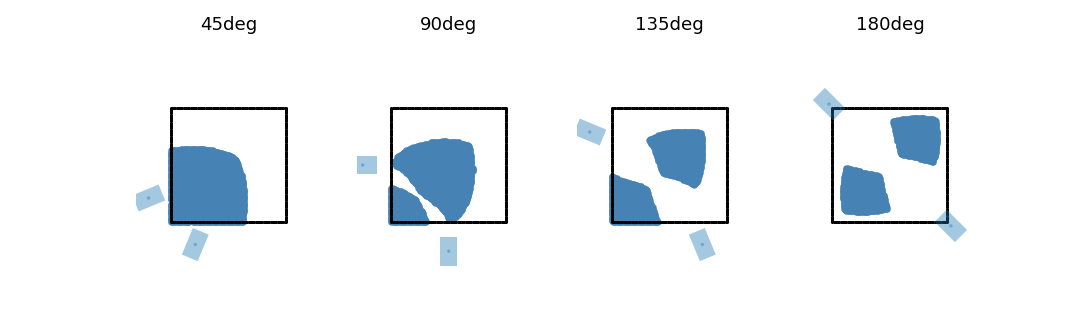

In [50]:
fig = plt.figure(figsize=(10, 3))

lim = 0.16

ax = fig.add_subplot(141)
ax.scatter(p_ws_45_in[:,0],p_ws_45_in[:,1], color='steelblue',alpha=1., s = 10, rasterized=True)
ax.scatter(p_ws_45_side[:,0],p_ws_45_side[:,1], color='black',alpha=1., s = 1, rasterized=True)
coll = Coils2DPatch(coil_length,coil_width,cal_path_mns2)
ax.add_collection(coll)
ax.axis('equal')
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_title('45deg')
ax.axis('off')

ax = fig.add_subplot(142)
ax.scatter(p_ws_90_in[:,0],p_ws_90_in[:,1], color='steelblue',alpha=1., s = 10, rasterized=True)
ax.scatter(p_ws_90_side[:,0],p_ws_90_side[:,1], color='black',alpha=1., s = 1., rasterized=True)
coll = Coils2DPatch(coil_length,coil_width,cal_path_mns1)
ax.add_collection(coll)
ax.axis('equal')
ax.set_title('90deg')
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.axis('off')

ax = fig.add_subplot(143)
ax.scatter(p_ws_135_in[:,0],p_ws_135_in[:,1], color='steelblue',alpha=1., s = 10, rasterized=True)
ax.scatter(p_ws_135_side[:,0],p_ws_135_side[:,1], color='black',alpha=1., s = 1., rasterized=True)
coll = Coils2DPatch(coil_length,coil_width,cal_path_mns3)
ax.add_collection(coll)
ax.axis('equal')
ax.set_title('135deg')
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.axis('off')

ax = fig.add_subplot(144)
ax.scatter(p_ws_180_in[:,0],p_ws_180_in[:,1], color='steelblue',alpha=1, s = 10, rasterized=True)
ax.scatter(p_ws_180_side[:,0],p_ws_180_side[:,1], color='black',alpha=1., s = 1., rasterized=True)
coll = Coils2DPatch(coil_length,coil_width,cal_path_mns4)
ax.add_collection(coll)
ax.axis('equal')
ax.set_title('180deg')
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.axis('off')

plt.show()

<IPython.core.display.Javascript object>


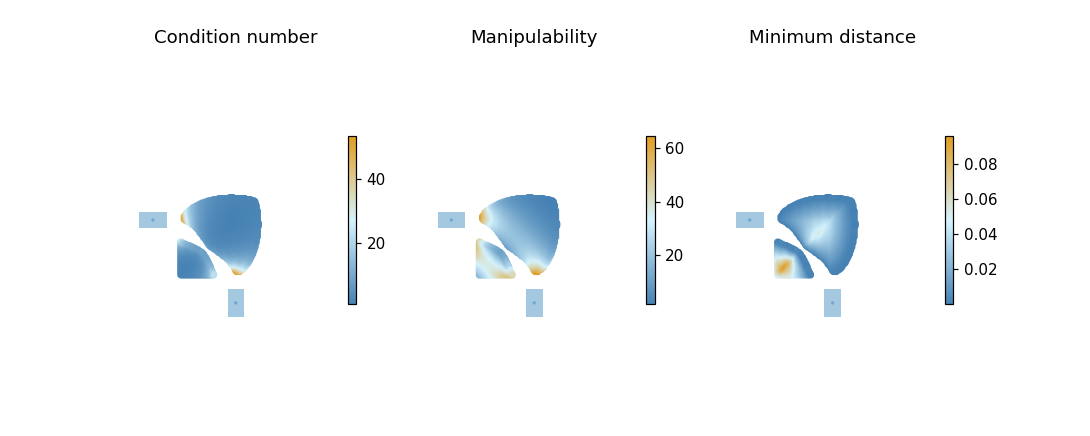

In [51]:
fig = plt.figure(figsize=(10,4))

lim = 0.18

ax = fig.add_subplot(131)
s1 = ax.scatter(p_ws_90_in[:,0],p_ws_90_in[:,1], c=kappa_90,alpha=1., s = 10, cmap = cmp_blue_3col, rasterized=True)
coll = Coils2DPatch(coil_length,coil_width,cal_path_mns1)
ax.add_collection(coll)
ax.axis('equal')
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_title('Condition number')
ax.axis('off')
fig.colorbar(s1, ax=ax,shrink=0.5)

ax = fig.add_subplot(132)
s2 = ax.scatter(p_ws_90_in[:,0],p_ws_90_in[:,1], c=mu_90,alpha=1., s = 10,cmap = cmp_blue_3col, rasterized=True)
coll = Coils2DPatch(coil_length,coil_width,cal_path_mns1)
ax.add_collection(coll)
ax.axis('equal')
ax.set_title('Manipulability')
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.axis('off')
fig.colorbar(s2, ax=ax,shrink=0.5)

ax = fig.add_subplot(133)
s2 = ax.scatter(p_ws_90_in[:,0],p_ws_90_in[:,1], c=minDist_90,alpha=1., s = 10,cmap = cmp_blue_3col, rasterized=True)
coll = Coils2DPatch(coil_length,coil_width,cal_path_mns1)
ax.add_collection(coll)
ax.axis('equal')
ax.set_title('Minimum distance')
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.axis('off')
fig.colorbar(s2, ax=ax,shrink=0.5)


### Inflence of the coils' distance

In [52]:
# Load systems calibration
cal_path_mns21 = 'models/mns_2coils_parallel_50.yaml'
model_para_50 = ForwardModelMPEM()
model_para_50.setCalibrationFile(cal_path_mns21)

cal_path_mns22 = 'models/mns_2coils_parallel_100.yaml'
model_para_100 = ForwardModelMPEM()
model_para_100.setCalibrationFile(cal_path_mns22)

cal_path_mns23 = 'models/mns_2coils_parallel_150.yaml'
model_para_150 = ForwardModelMPEM()
model_para_150.setCalibrationFile(cal_path_mns23)

cal_path_mns24 = 'models/mns_2coils_parallel_200.yaml'
model_para_200 = ForwardModelMPEM()
model_para_200.setCalibrationFile(cal_path_mns24)

In [56]:
Nx = 100
Ny = 100

p_ws_50_in, p_ws_50_out, p_ws_50_side, kappa_50, mu_50, gci, minDist_50 = Ws2DDeterminationDiscr(Nx,Ny,pmin,pmax,bmin,bmax,Imin,Imax,model_para_50)
print(gci)
p_ws_100_in, p_ws_100_out, p_ws_100_side, kappa_100, mu_100, gci, minDist_100 = Ws2DDeterminationDiscr(Nx,Ny,pmin,pmax,bmin,bmax,Imin,Imax,model_para_100)
print(gci)
p_ws_150_in, p_ws_150_out, p_ws_150_side, kappa_150, mu_150, gci, minDist_150 = Ws2DDeterminationDiscr(Nx,Ny,pmin,pmax,bmin,bmax,Imin,Imax,model_para_150)
print(gci)
p_ws_200_in, p_ws_200_out, p_ws_200_side, kappa_200, mu_20, gci, minDist_200 = Ws2DDeterminationDiscr(Nx,Ny,pmin,pmax,bmin,bmax,Imin,Imax,model_para_200)
print(gci)

0.27401870864245603
0.34051192325169805
0.33203455790612835
0.4089052133135028


<IPython.core.display.Javascript object>


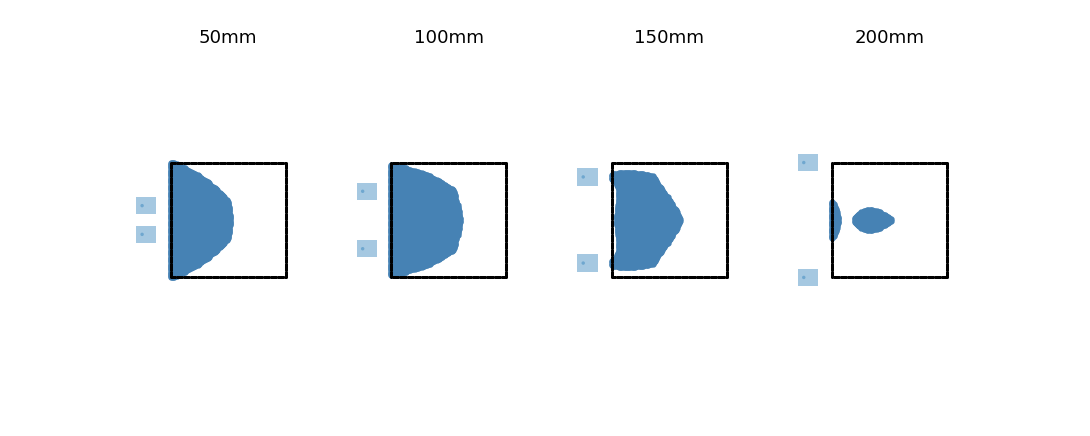

In [57]:
fig = plt.figure(figsize=(10, 4))

lim = 0.16

ax = fig.add_subplot(141)
ax.scatter(p_ws_50_in[:,0],p_ws_50_in[:,1], color='steelblue',alpha=1., s = 10, rasterized=True)
ax.scatter(p_ws_50_side[:,0],p_ws_50_side[:,1], color='black',alpha=1., s = 1, rasterized=True)
coll = Coils2DPatch(coil_length,coil_width,cal_path_mns21)
ax.add_collection(coll)
ax.axis('equal')
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_title('50mm')
ax.axis('off')

ax = fig.add_subplot(142)
ax.scatter(p_ws_100_in[:,0],p_ws_100_in[:,1], color='steelblue',alpha=1., s = 10, rasterized=True)
ax.scatter(p_ws_100_side[:,0],p_ws_100_side[:,1], color='black',alpha=1., s = 1., rasterized=True)
coll = Coils2DPatch(coil_length,coil_width,cal_path_mns22)
ax.add_collection(coll)
ax.axis('equal')
ax.set_title('100mm')
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.axis('off')

ax = fig.add_subplot(143)
ax.scatter(p_ws_150_in[:,0],p_ws_150_in[:,1], color='steelblue',alpha=1., s = 10, rasterized=True)
ax.scatter(p_ws_150_side[:,0],p_ws_150_side[:,1], color='black',alpha=1., s = 1., rasterized=True)
coll = Coils2DPatch(coil_length,coil_width,cal_path_mns23)
ax.add_collection(coll)
ax.axis('equal')
ax.set_title('150mm')
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.axis('off')

ax = fig.add_subplot(144)
ax.scatter(p_ws_200_in[:,0],p_ws_200_in[:,1], color='steelblue',alpha=1, s = 10, rasterized=True)
ax.scatter(p_ws_200_side[:,0],p_ws_200_side[:,1], color='black',alpha=1., s = 1., rasterized=True)
coll = Coils2DPatch(coil_length,coil_width,cal_path_mns24)
ax.add_collection(coll)
ax.axis('equal')
ax.set_title('200mm')
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.axis('off')

plt.show()

## Four-coil systems

In [58]:
# Load systems calibration
cal_path_mns41 = 'models/mns_4coils_1.yaml'
model_4coil1 = ForwardModelMPEM()
model_4coil1.setCalibrationFile(cal_path_mns41)

cal_path_mns42 = 'models/mns_4coils_2.yaml'
model_4coil2 = ForwardModelMPEM()
model_4coil2.setCalibrationFile(cal_path_mns42)

In [59]:
Nx = 100
Ny = 100

p_ws_41_in, p_ws_41_out, p_ws_41_side, kappa_41, mu_41, gci, minDist_41 = Ws2DDeterminationDiscr(Nx,Ny,pmin,pmax,bmin,bmax,Imin/2,Imax/2,model_4coil1)
p_ws_42_in, p_ws_42_out, p_ws_42_side, kappa_42, mu_42, gci, minDist_42 = Ws2DDeterminationDiscr(Nx,Ny,pmin,pmax,bmin,bmax,Imin/2,Imax/2,model_4coil2)

<IPython.core.display.Javascript object>


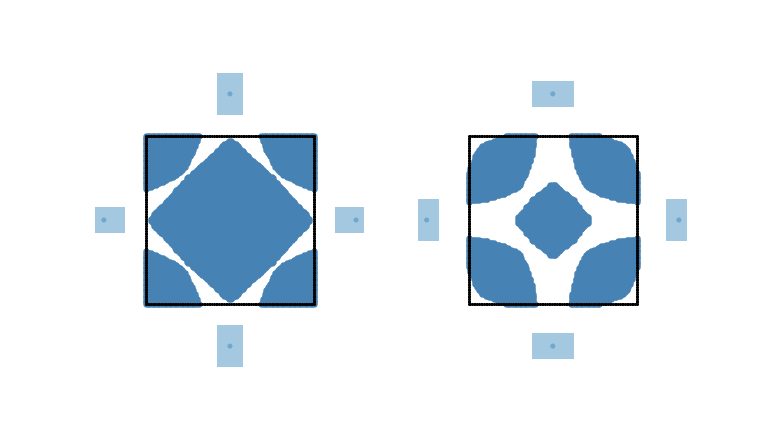

(-0.16, 0.16, -0.16, 0.16)

In [60]:
fig = plt.figure(figsize=(7, 4))

ax = fig.add_subplot(121)
ax.scatter(p_ws_41_in[:,0],p_ws_41_in[:,1], color='steelblue',alpha=1., s = 10, rasterized=True)
ax.scatter(p_ws_41_side[:,0],p_ws_41_side[:,1], color='black',alpha=1., s = 1., rasterized=True)
coll = Coils2DPatch(coil_length,coil_width,cal_path_mns41)
ax.add_collection(coll)
ax.axis('equal')
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.axis('off')

ax = fig.add_subplot(122)
ax.scatter(p_ws_42_in[:,0],p_ws_42_in[:,1], color='steelblue',alpha=1, s = 10, rasterized=True)
ax.scatter(p_ws_42_side[:,0],p_ws_42_side[:,1], color='black',alpha=1., s = 1., rasterized=True)
coll = Coils2DPatch(coil_length,coil_width,cal_path_mns42)
ax.add_collection(coll)
ax.axis('equal')
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.axis('off')

<IPython.core.display.Javascript object>


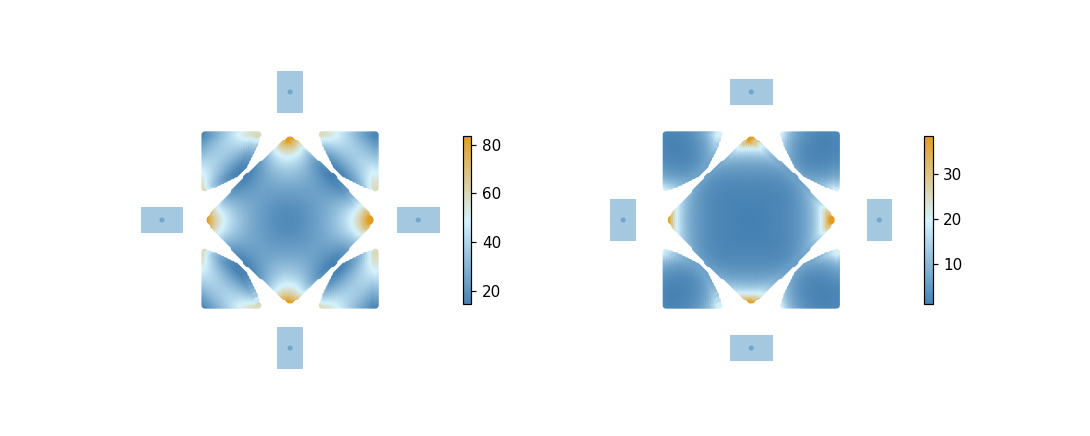

In [65]:
fig = plt.figure(figsize=(10,4))


lim = 0.18

ax = fig.add_subplot(121)
s1 = ax.scatter(p_ws_41_in[:,0],p_ws_41_in[:,1], c=mu_41,alpha=1.,cmap = cmp_blue_3col ,s = 10, rasterized=True)
coll = Coils2DPatch(coil_length,coil_width,cal_path_mns41)
ax.add_collection(coll)
ax.axis('equal')
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.axis('off')
fig.colorbar(s1, ax=ax,shrink=0.5)


ax = fig.add_subplot(122)
s2 = ax.scatter(p_ws_41_in[:,0],p_ws_41_in[:,1], c=kappa_41,alpha=1,cmap = cmp_blue_3col, s = 10, rasterized=True)
coll = Coils2DPatch(coil_length,coil_width,cal_path_mns42)
ax.add_collection(coll)
ax.axis('equal')
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.axis('off')
fig.colorbar(s2, ax=ax,shrink=0.5)

